In [1]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp
import jax.numpy.linalg as JLA

from jax.example_libraries import optimizers

import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from functools import partial
from sklearn.datasets import fetch_openml

In [2]:
A = jnp.array([[-0.2, 0.4, -1.0, -0.4],
    [-0.7, -0.8, -0.6, -0.3],
    [-0.2, 0.1, -0.2, 0.4],
    [-0.6, 0.8, -0.9, 0.3]])

B = jnp.array([[-0.2, 0.1],
    [-0.7, -0.6],
    [0.6, 0.9],
    [-0.4, 0.4]])

C = jnp.array([[0.8, 0.8, -0.8, -0.9],
    [-0.7, 0.8, -0.8, -0.2]])

In [3]:
K = jnp.array([[-2.7, 2.7],
                [2.7, -2.7]])

In [4]:
T = 50.0
N = 1000
eta = T/N
mbs = 100
std = 0.4
ub = 3.0

In [5]:
@jax.jit
def EM(K, T):
    eta = T/N
    x = jnp.ones((4, mbs))
    for i in range(N):
        x += eta * (A + B @ K @ C) @ x + std * jnp.sqrt(eta) * jnp.array(np.random.randn(4, mbs))
    s = jnp.sqrt(jnp.sum(x**2, axis=0))
    ave = jnp.sum(s)/mbs
    stdv = jnp.sqrt(jnp.sum((s - ave)**2)/mbs)
    return ave, stdv

In [6]:
max_itr = 40
AVE = jnp.zeros(max_itr)
STDV = jnp.zeros(max_itr)
Trange = jnp.zeros(max_itr)

for i in range(max_itr):
    Trange = Trange.at[i].set(0.5 * i)
    ave, stdv = EM(K, 0.5*i)
    AVE = AVE.at[i].set(ave)
    STDV = STDV.at[i].set(stdv)

In [7]:
df = pd.DataFrame()
df["t"] = Trange
df["ave"] = AVE
df["stdv"] = STDV

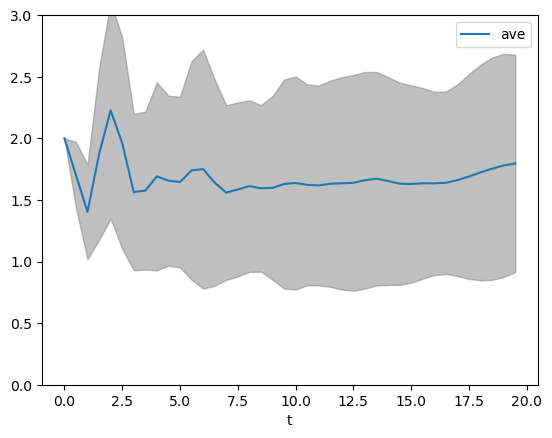

In [8]:
fig, ax = plt.subplots()
df.plot(df.columns[0], y = df.columns[1],  ax = ax)
ax.set_ylim(0, 3)
plt.fill_between(df["t"], df["ave"] + df["stdv"], df["ave"] - df["stdv"], color='gray', alpha=0.5);

In [9]:
# @jax.jit
def DU_EM(T, K):
    eta = T/N
    x = jnp.array(np.random.randn(4, mbs))
    for i in range(N):
        x += eta * (A + B @ K @ C) @ x + jnp.sqrt(eta) * jnp.array(np.random.randn(4, mbs))
    return jnp.sum(x**2)

In [20]:
adam_lr = 5*1e-4
train_itr = 400

opt_init, opt_update, get_params = optimizers.adam(adam_lr)

def train(gain_k):
    opt_state = opt_init(gain_k)
    for i in trange(train_itr):
        value, grads = jax.value_and_grad(DU_EM, argnums=-1)(20, gain_k)
        opt_state = opt_update(i, grads, opt_state)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return get_params(opt_state)

In [21]:
gain_k_init = jnp.copy(K)
gain_k_trained = train(gain_k_init)

  0%|          | 0/400 [00:00<?, ?it/s]

loss:2266.63232421875   

In [22]:
max_itr = 40
AVE = jnp.zeros(max_itr)
STDV = jnp.zeros(max_itr)
Trange = jnp.zeros(max_itr)

for i in range(max_itr):
    Trange = Trange.at[i].set(0.5 * i)
    ave, stdv = EM(gain_k_trained, 0.5*i)
    AVE = AVE.at[i].set(ave)
    STDV = STDV.at[i].set(stdv)

In [23]:
df2 = pd.DataFrame()
df2["t"] = Trange
df2["ave"] = AVE
df2["stdv"] = STDV

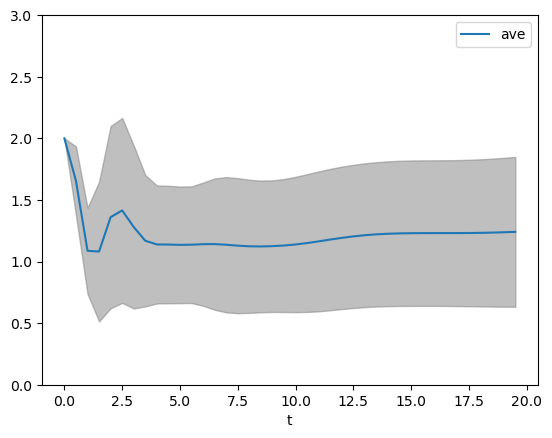

In [24]:
_, ax2 = plt.subplots()
df2.plot(df2.columns[0], y = df2.columns[1],  ax = ax2)
ax2.set_ylim(0, 3)
plt.fill_between(df2["t"], df2["ave"] + df2["stdv"], df2["ave"] - df2["stdv"], color='gray', alpha=0.5);